In [40]:
import numpy as np
import pandas as pd
import json
import sklearn.metrics as metrics
from sklearn import cross_validation
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\sienc\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('params.json') as data_file:    
    params = json.load(data_file)

##### Загрузка событий, G - штатные, A - нештатные

In [3]:
def load_data(prefix):
    filename = 'datasets/' + prefix + str(params['dataset'] - 1) + '.csv'
    raw_df = pd.read_csv(filename)
    rows_count = raw_df.shape[0]
    bits_count = len(raw_df.ix[0,:].bin)
    res = np.zeros(( rows_count, bits_count ), dtype=np.int)
    for i in np.arange(rows_count):
        res[i] = np.array(list(raw_df.ix[i,:].bin), dtype=int)
    return res
G = load_data('normal')
A = load_data('attack')
bits_count = len(A[0]) # длина строки

##### Обучающая выборка

In [49]:
X_train = np.append(G, A, axis = 0)
Y_train = np.append(np.zeros(G.shape[0], dtype = np.int), np.ones(A.shape[0], dtype = int), axis = 0)
permutation = np.random.permutation(len(Y_train))
Y_train = Y_train[permutation]
X_train = X_train[permutation]

##### Контрольная выборка

In [4]:
df_test = pd.read_csv('datasets/test' + str(params['dataset'] - 1) + '.csv')
X_test = np.zeros(( df_test.shape[0], bits_count ), dtype=np.int)
Y_test = np.zeros(df_test.shape[0], dtype=np.int)
for i in np.arange(X_test.shape[0]):
    X_test[i] = np.array(list(df_test.ix[i,:].bin), dtype=int)
    Y_test[i] = df_test.ix[i,:].type

# 1. Эволюционный иммунный алгоритм клональной селекции
### Почти как в статье, только:
### нет взаимно однозначного соответствия между антигеном и детектором (другая целевая функция),
### не используются стратегии отбора при выборе потомков и выборе подмножества детекторов S,
### не используется генератор случайных чисел, нет вероятности мутации.
http://cyberleninka.ru/article/n/obnaruzhenie-setevyh-vtorzheniy-evolyutsionnym-immunnym-algoritmom-klonalnoy-selektsii

##### Начальное заполнение множества детекторов D

In [5]:
def create_detectors_set(dev):
    if (dev):
        np.random.seed(42) # для повторяемости
    D = np.zeros(( params['detectors_count'], bits_count ), dtype=np.int)
    for i in np.arange(D.shape[0]):
        D[i] = np.random.randint(2, size = D.shape[1])
    return D

##### Выбрать подмножество детекторов для скрещивания и мутаций

In [6]:
def detectors_subset(S_size): # выбираем случайным образом
    return D[np.random.randint(D.shape[0], size=S_size), :]

##### Генерировать множество детекторов-потомков

In [7]:
def generate_new_detectors(S):
    elements_number = S.shape[0] 
    K = np.zeros((elements_number * 2, S.shape[1]), dtype=np.int)
    for i in np.arange(elements_number):
        x = S[np.random.randint(S.shape[0]), :].copy() # выбираем элементы для скрещивания случайным образом
        y = S[np.random.randint(S.shape[0]), :].copy()
        
        number_of_positions = 5 
        
        # позиции для скрещивания выбираются случайным образом
        positions = np.random.randint(S.shape[0], size = number_of_positions) 
        positions.sort()
        
        for j in np.arange(number_of_positions - 1): # поточечное скрещивание
            cur_pos = positions[j]
            next_pos = positions[j+1]
            z = x[cur_pos : next_pos].copy()
            x[cur_pos : next_pos] = y[cur_pos : next_pos].copy()
            y[cur_pos : next_pos] = z       
        
        K[i] = x
        K[elements_number + i] = y
    
    return K

##### Мутации во множестве детекторов-потомков

In [8]:
def mutations(K):
    for i in np.arange(K.shape[0]):
        number_of_mutations = 1
        for j in np.arange(number_of_mutations):
            # мутация должна происходить с вероятностью 1/y, где y - мера аффинности данного антитела
            pos = np.random.randint(bits_count)
            K[i, pos] = (K[i, pos] + 1) % 2 

###### Шаг генетического алгоритма

In [9]:
def ga_step(Y, S_size):
    convergence = False # достигнута ли сходимость
    
    S = detectors_subset(S_size)
    K = generate_new_detectors(S)
    mutations(K)
    Affin_K = calculate_affinity_for_set(K, R)
    
    # нужно перенести лучших потомков в исходный массив
    # стратегия отбора: просто взять n лучших
    n = 10
    for i in np.arange(n):
        bad_in_detectors = Y.argmin()
        best_in_childrens = Affin_K.argmax()
        
        Y[bad_in_detectors] = Affin_K[best_in_childrens]
        Affin_K[best_in_childrens] = 0
        
        D[bad_in_detectors] = K[best_in_childrens].copy()
    
    target_function_value = target_function(R)
    if target_function_value > 0.95: # ещё один параметр!
        convergence = True
    
    return convergence, target_function_value

##### Вычислить целевую функцию - количество обнаруженных

In [10]:
def target_function(R):
    res = 0.0
    for i in np.arange(A.shape[0]):
        attack_pattern = ''.join(str(x) for x in A[i,:])  
        pattern_was_recognized = False
        
        for z in np.arange(D.shape[0]):
            detector = ''.join(str(x) for x in D[z,:])           
            
            for j in np.arange(0, len(attack_pattern) - R):
                pattern_part = attack_pattern[j:j+R]
                if detector.find(pattern_part) > 0:
                    pattern_was_recognized = True
                    break
                    
            if pattern_was_recognized:
                break
        
        if pattern_was_recognized:
            res += 1
            
    return res / A.shape[0]

##### Вычислить аффинность для элемента

In [11]:
def calculate_affinity_for_elem(elem, R): # просто r-подобие строк
    res = 0.0
    detector = ''.join(str(x) for x in elem)
    
    for i in np.arange(A.shape[0]):        
        attack_pattern = ''.join(str(x) for x in A[i,:])
        
        for j in np.arange(0, len(attack_pattern) - R):
            pattern_part = attack_pattern[j:j+R]
            if detector.find(pattern_part) > 0:
                res += 1
                break
         
    return res / A.shape[0]        

##### Посчитать аффинность для каждого элемента из множества

In [12]:
def calculate_affinity_for_set(SET, R):
    Y = np.zeros((SET.shape[0], 1))
    for i in np.arange(SET.shape[0]):
        Y[i] = calculate_affinity_for_elem(SET[i,:], R)
    return Y

##### Обучение - т.е формирование множества детекторов

In [13]:
def AIS(P, R, S_size, do_print):
    Y = calculate_affinity_for_set(D, R) # вычисление первоначальных значений меры для детекторов
    for i in np.arange(P):
        convergence, target_function_value = ga_step(Y, S_size)
            
        if (do_print):
            print( str(i) + ': ' + str(target_function_value) )
         
        if (convergence):
                break
        
    return target_function_value, i

##### Дать ответ на множестве

In [14]:
def prediction(gene_set, R): # refactoring: копипаста вычисления меры!
    res = np.zeros( (gene_set.shape[0], 1) , dtype=np.int)
    for i in np.arange(gene_set.shape[0]):
        pattern = ''.join(str(x) for x in gene_set[i, :])
        pattern_class = 0 # 0 - нормальное состояние, 1 - атака
        
        for z in np.arange(D.shape[0]):
            detector = ''.join(str(x) for x in D[z,:])           

            for j in np.arange(0, len(pattern) - R):
                pattern_part = pattern[j:j+R]
                if detector.find(pattern_part) > 0:
                    pattern_class = 1
                    break

            if pattern_class == 1:
                    break
                    
        res[i] = pattern_class
    return res

##### Вычислить метрики качества

In [16]:
def calculate_metrics(predictions_array, answers_array): 

    accuracy_val = metrics.accuracy_score(predictions_array, answers_array)
    precision_val = metrics.precision_score(predictions_array, answers_array)
    recall_val = metrics.recall_score(predictions_array, answers_array)
    f_val = metrics.f1_score(predictions_array, answers_array)
    
    # доля правильных ответов, точность, полнота, f-мера
    return accuracy_val, precision_val, recall_val, f_val

##### Параметры для алгоритма по-умолчанию из файла params

In [17]:
P = params['max_epoch'] # предельное количество шагов обучения генетического алгоритма
S_size = params['S_count'] # размер подмножества детекторов для шага генетического алгоритма
R = params['r']

##### Пример запуска алгоритма (без модификаций)

In [ ]:
%%time
D = create_detectors_set(True)
target_function_value, step = AIS(P, R, S_size, True)
print( 'target function in the end of learning: ' + str(target_function_value) )
print( 'final step in learning: ' + str(step)) 

In [ ]:
predictions = prediction(X_train, R)
accuracy, precision, recall, f = calculate_metrics(predictions, Y_train)
print('accuracy: ' + str(accuracy))
print('precision: ' + str(precision))
print('recall: ' + str(recall))
print('f-score: ' + str(f))

##### Будем измерять метрики качества в зависимости от R (параметра выбранной меры схожести)

In [19]:
r_grid = [10, 15, 20, 25, 30, 40, 50]

In [ ]:
%%time
P = 200 # т.к. очень медленно работает

accuracy_scores = np.zeros(len(r_grid))
precision_scores = np.zeros(len(r_grid))
recall_scores = np.zeros(len(r_grid))
f_scores = np.zeros(len(r_grid))

for i, R in enumerate(r_grid):
    D = create_detectors_set(False)
    AIS(P, R, S_size, True)
    predictions = prediction(X_test, R)
    accuracy, precision, recall, f = calculate_metrics(predictions, Y_test)
    
    accuracy_scores[i] = accuracy
    precision_scores[i] = precision
    recall_scores[i] = recall
    f_scores[i] = f
    
    print (str(R) + '-r step has been finished')

np.savetxt('experiments/2_accuracy.txt', accuracy_scores)
np.savetxt('experiments/2_precision.txt', precision_scores)
np.savetxt('experiments/2_recall.txt', recall_scores)
np.savetxt('experiments/2_f.txt', f_scores)

TP - true positive
FP - false positive
FN - false negative
\begin{equation*}
precision = \frac{TP}{TP + FP}
\end{equation*}

\begin{equation*}
recall= \frac{TP}{TP + FN}
\end{equation*}

\begin{equation*}
f= \frac{precision * recall}{precision + recall}
\end{equation*}

In [27]:
def simple_plot1(y1, y2, title):
    pylab.plot(r_grid, y1, 'g-', label='epoch = 100')
    pylab.plot(r_grid, y2, 'b-', label='epoch = 200')
    pylab.grid(True)
    pylab.xlabel('r')
    pylab.ylabel('score')
    pylab.title(title)
    pylab.legend(loc='lower right')

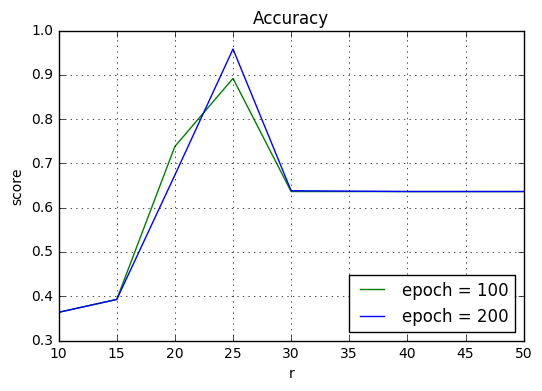

In [39]:
simple_plot1(np.loadtxt('experiments/1_accuracy.txt'), np.loadtxt('experiments/2_accuracy.txt'), 'Accuracy')
# на 30 доля правильных ответов остановилась, т.к. не было предсказаний первого класса (т.е. атак)

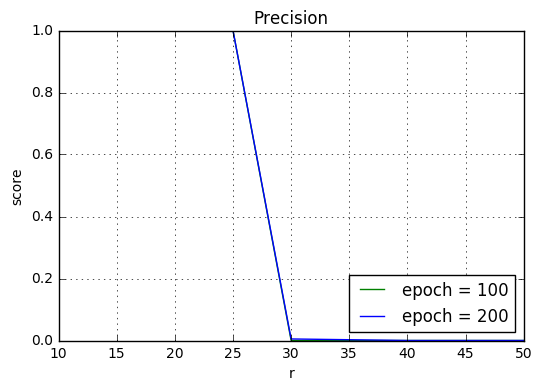

In [38]:
simple_plot1(np.loadtxt('experiments/1_precision.txt'), np.loadtxt('experiments/2_precision.txt'), 'Precision')

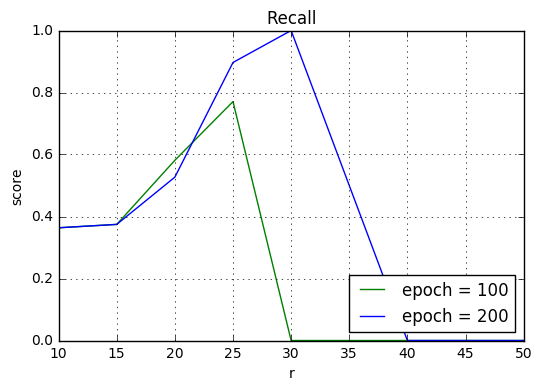

In [37]:
simple_plot1(np.loadtxt('experiments/1_recall.txt'), np.loadtxt('experiments/2_recall.txt'), 'Recall')

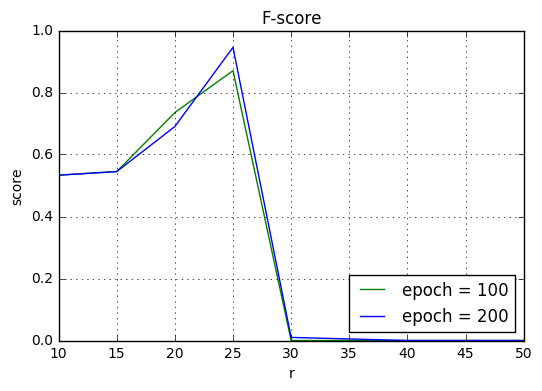

In [36]:
simple_plot1(np.loadtxt('experiments/1_f.txt'), np.loadtxt('experiments/2_f.txt'), 'F-score')

# 1.1 Стандартный градиентный бустинг по решающим деревьям

In [42]:
import os 
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH'] # Windows OS only
import xgboost as xgb

In [54]:
estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)
#score = cross_validation.cross_val_score(estimator, X_test, Y_test, scoring = 'accuracy', cv = 3)
#print score
estimator.fit(X_train, Y_train)
print( metrics.mean_squared_error( estimator.predict(X_test), Y_test)  )

0.00454545454545
